# Understanding time series forecasting

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Introducing time series

In [3]:
df = pd.read_csv("data/quarterly_earnings.csv")
df['year'] = pd.DatetimeIndex(df['date']).year
df.head()

,date,data,year
0,1960-01-01,0.71,1960
1,1960-04-01,0.63,1960
2,1960-07-02,0.85,1960
3,1960-10-01,0.44,1960
4,1961-01-01,0.61,1961


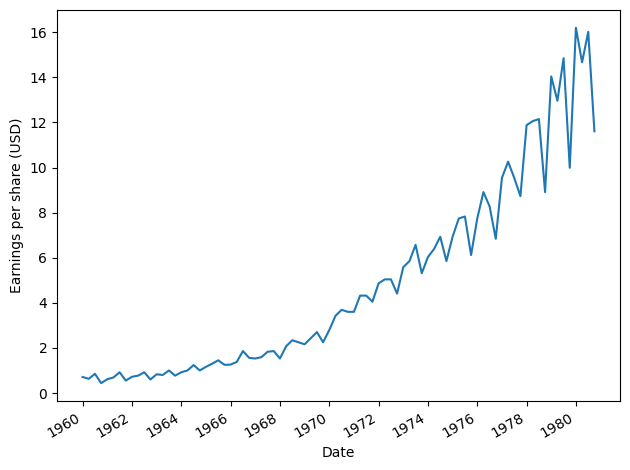

In [4]:
fig, ax = plt.subplots()

ax.plot(df.date, df.data)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')

plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

**Visualizing the components of a time series is known as `decomposition`**. 


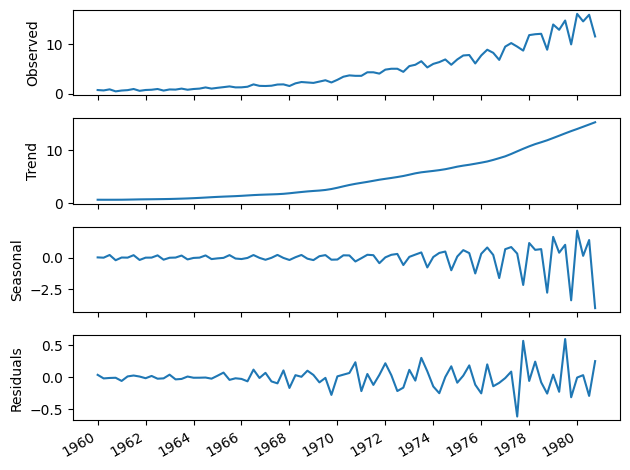

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL

advanced_decomposition = STL(df.data, period=4).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')


plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

## Bird’s-eye view of time series forecasting

<img src="images/tsf_01.png">

Forecasting project roadmap.
1. **The first step is naturally to set a goal that justifies the need for forecasting.**
2. **Then you must determine what needs to be forecast in order to achieve that goal.**
3. **Then you set the horizon of the forecast.**
4. **Once that’s done, you can gather the data and develop a forecasting model.**
5. **Then the model is deployed to production, its performance is monitored, and new data is collected in order to retrain the forecasting model and make sure it is still relevant.**

> It is important to have a goal when forecasting and to monitor the model once
it’s deployed. This will ensure the success and longevity of the project.

## How time series forecasting is different from other regression tasks

However, there are some key differences between time series forecasting and regression
for time-independent scenarios:
- **Time series have an order**
- **Time series sometimes do not have features**

> Never change the order of a time series when modeling. Shuffling the data is
not allowed.

## Defining a baseline model

- In the context of time series, **one simple statistic we can use to build a baseline is the
arithmetic mean.**

- Another possible baseline is to naively forecast the **last recorded data point**.

- Or, if we see a cyclical pattern in our data, we can **simply repeat that pattern into the
future.**

> A baseline model is a trivial solution to our forecasting problem because it only
uses heuristics, or simple statistics, such as the mean.

## Forecasting the historical mean

In [6]:
df.head()

,date,data,year
0,1960-01-01,0.71,1960
1,1960-04-01,0.63,1960
2,1960-07-02,0.85,1960
3,1960-10-01,0.44,1960
4,1961-01-01,0.61,1961


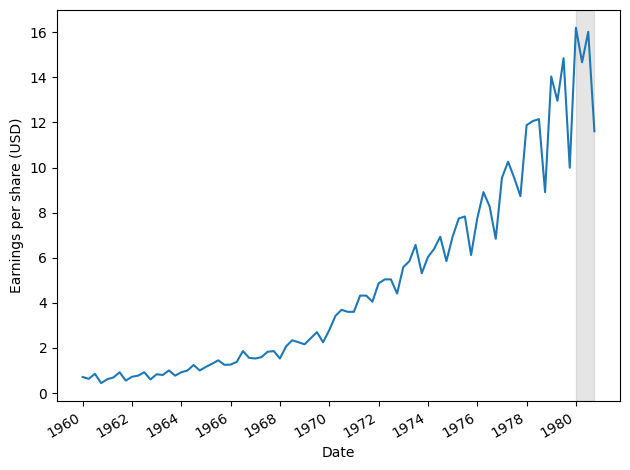

In [8]:
fig, ax = plt.subplots()

ax.plot(df['date'], df['data'])
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [9]:
train = df[:-4].copy()
test = df[-4:].copy()

In [10]:
historical_mean = np.mean(train['data'])
historical_mean

4.308499987499999

In [11]:
test.loc[:, 'pred_mean'] = historical_mean
test

,date,data,year,pred_mean
80,1980-01-01,16.20,1980,4.3085
81,1980-04-01,14.67,1980,4.3085
82,1980-07-02,16.02,1980,4.3085
83,1980-10-01,11.61,1980,4.3085


Next, we need to define and **calculate an error metric in order to evaluate the performance
of our forecasts on the test set.**

In [13]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [14]:
mape_hist_mean = mape(test['data'], test['pred_mean'])
mape_hist_mean

70.00752579965119

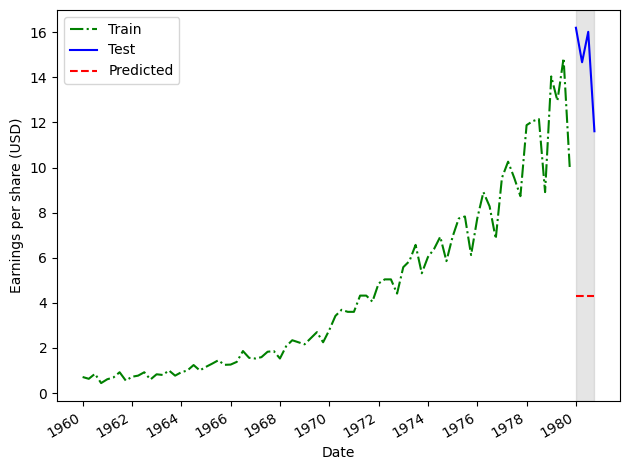

In [15]:
fig, ax = plt.subplots()

ax.plot(train['date'], train['data'], 'g-.', label='Train')
ax.plot(test['date'], test['data'], 'b-', label='Test')
ax.plot(test['date'], test['pred_mean'], 'r--', label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)
ax.legend(loc=2)

plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

## Forecasting last year’s mean

In [16]:
last_year_mean = np.mean(train['data'][-4:])
last_year_mean

12.96

In [18]:
test.loc[:, 'pred__last_yr_mean'] = last_year_mean

test

,date,data,year,pred_mean,pred__last_yr_mean
80,1980-01-01,16.20,1980,4.3085,12.96
81,1980-04-01,14.67,1980,4.3085,12.96
82,1980-07-02,16.02,1980,4.3085,12.96
83,1980-10-01,11.61,1980,4.3085,12.96


In [19]:
mape_last_year_mean = mape(test['data'], test['pred__last_yr_mean'])
mape_last_year_mean

15.5963680725103

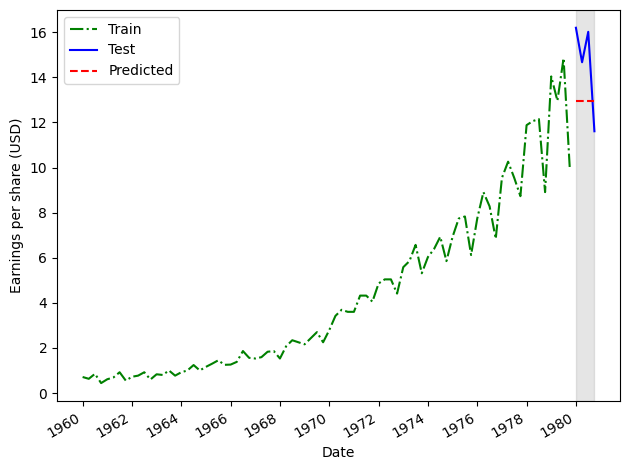

In [20]:
fig, ax = plt.subplots()

ax.plot(train['date'], train['data'], 'g-.', label='Train')
ax.plot(test['date'], test['data'], 'b-', label='Test')
ax.plot(test['date'], test['pred__last_yr_mean'], 'r--', label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)
ax.legend(loc=2)

plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

## Predicting using the last known value

In [21]:
last = train['data'].iloc[-1]
last

9.99

In [22]:
test.loc[:, 'pred_last'] = last

test

,date,data,year,pred_mean,pred__last_yr_mean,pred_last
80,1980-01-01,16.20,1980,4.3085,12.96,9.99
81,1980-04-01,14.67,1980,4.3085,12.96,9.99
82,1980-07-02,16.02,1980,4.3085,12.96,9.99
83,1980-10-01,11.61,1980,4.3085,12.96,9.99


In [23]:
mape_last = mape(test['data'], test['pred_last'])
mape_last

30.457277908606535

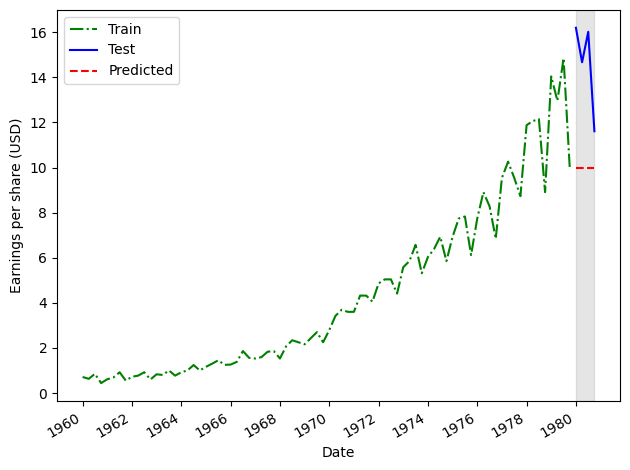

In [24]:
fig, ax = plt.subplots()

ax.plot(train['date'], train['data'], 'g-.', label='Train')
ax.plot(test['date'], test['data'], 'b-', label='Test')
ax.plot(test['date'], test['pred_last'], 'r--', label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)
ax.legend(loc=2)

plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

## Implementing the naive seasonal forecast

In [25]:
test.loc[:, 'pred_last_season'] = train['data'][-4:].values

test

,date,data,year,pred_mean,pred__last_yr_mean,pred_last,pred_last_season
80,1980-01-01,16.20,1980,4.3085,12.96,9.99,14.04
81,1980-04-01,14.67,1980,4.3085,12.96,9.99,12.96
82,1980-07-02,16.02,1980,4.3085,12.96,9.99,14.85
83,1980-10-01,11.61,1980,4.3085,12.96,9.99,9.99


In [26]:
mape_naive_seasonal = mape(test['data'], test['pred_last_season'])
mape_naive_seasonal

11.561658552433654

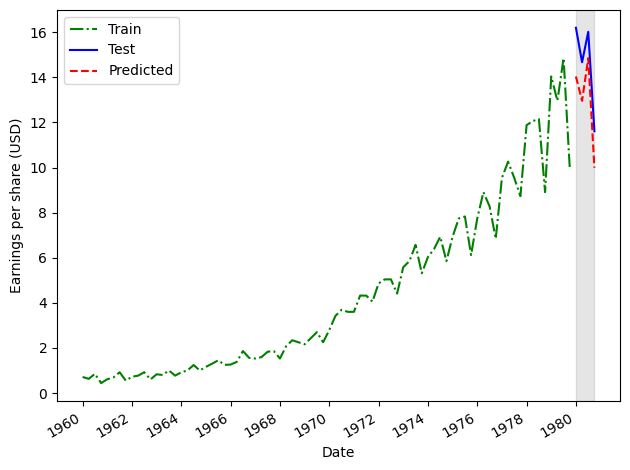

In [27]:
fig, ax = plt.subplots()

ax.plot(train['date'], train['data'], 'g-.', label='Train')
ax.plot(test['date'], test['data'], 'b-', label='Test')
ax.plot(test['date'], test['pred_last_season'], 'r--', label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)
ax.legend(loc=2)

plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

**Keep in mind that a baseline model serves as a basis for comparison.**

> Time series forecasting starts with a baseline model that serves as a benchmark
for comparison with more complex models.

## The random walk process

OHLCV podatki za Google

In [30]:
df = pd.read_csv('data/GOOGL.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-04-27,1292.000000,1294.099976,1265.060059,1270.859985,1270.859985,2209300
1,2020-04-28,1283.199951,1284.760010,1230.380005,1232.589966,1232.589966,4035000
2,2020-04-29,1345.000000,1360.150024,1326.729980,1342.180054,1342.180054,5417900
3,2020-04-30,1331.359985,1350.000000,1321.500000,1346.699951,1346.699951,2792100
4,2020-05-01,1324.089966,1351.430054,1309.660034,1317.319946,1317.319946,2443600


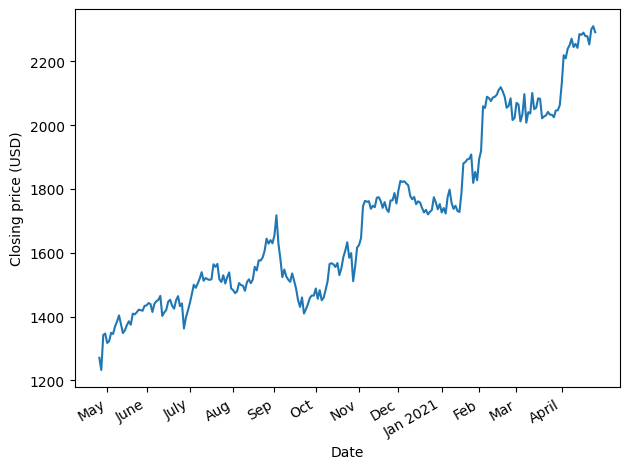

In [31]:
fig, ax = plt.subplots()

ax.plot(df['Date'], df['Close'])
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (USD)')

plt.xticks(
    [4, 24, 46, 68, 89, 110, 132, 152, 174, 193, 212, 235], 
    ['May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2021', 'Feb', 'Mar', 'April'])

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

**A random walk is a process in which there is an equal chance of going up or down by a
random number.** This is usually observed in **financial and economic data**.

### Simulating a random walk process

In [32]:
np.random.seed(42)

In [33]:
steps = np.random.standard_normal(1000)

In [35]:
steps[:5]

array([ 0.        , -0.1382643 ,  0.64768854,  1.52302986, -0.23415337])

In [34]:
steps[0]=0

In [36]:
random_walk = np.cumsum(steps)

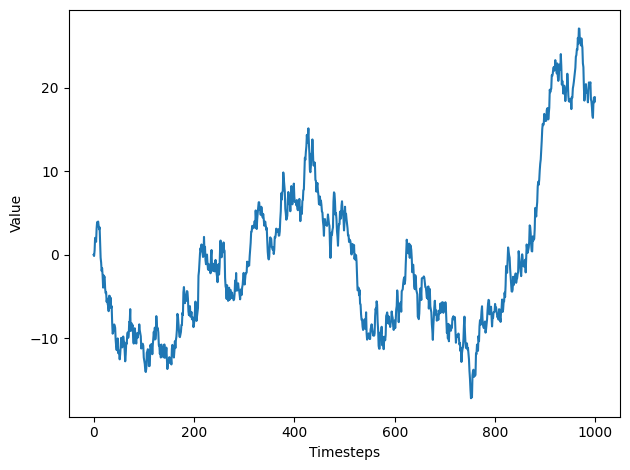

In [37]:
fig, ax = plt.subplots()

ax.plot(random_walk)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()
plt.show()

## Identifying a random walk

In the context of time series, a **random walk is defined
as a series whose first difference is stationary and uncorrelated.**

> **This means that the process moves completely at random.**

<img src="images/tsf_02.png">

### Stationarity

A stationary time series is one whose **statistical properties do not change over time**. In
other words, it **has a constant mean, variance, and autocorrelation, and these properties
are independent of time**.

> The augmented Dickey-Fuller (ADF) test helps us determine if a time series is stationary
by testing for the presence of a unit root. If a unit root is present, the time series
is not stationary.

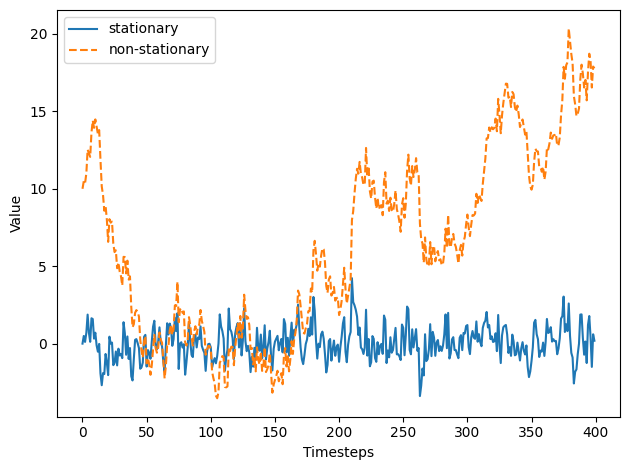

In [38]:
def simulate_process(is_stationary: bool) -> np.array:
    np.random.seed(42)
    process = np.empty(400)
    
    if is_stationary:
        alpha = 0.5
        process[0] = 0
    else:
        alpha = 1
        process[0] = 10
        
    for i in range(400):
        if i+1 < 400:
            process[i+1] = alpha*process[i] + np.random.standard_normal()
        else:
            break
        
    return process

stationary = simulate_process(True)
non_stationary = simulate_process(False)

fig, ax = plt.subplots()

ax.plot(stationary, linestyle='-', label='stationary')
ax.plot(non_stationary, linestyle='--', label='non-stationary')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
ax.legend(loc=2)

plt.tight_layout()
plt.show()

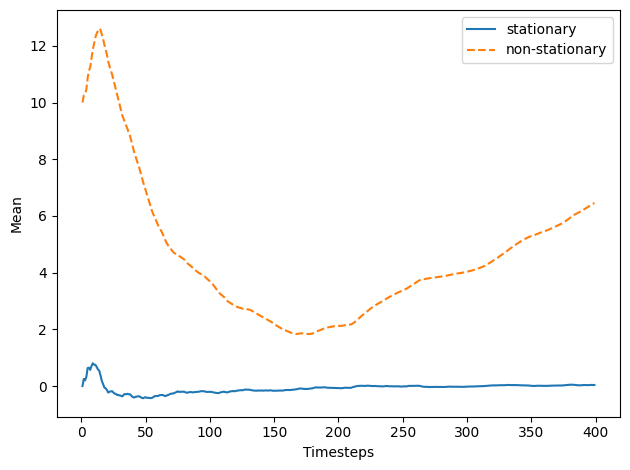

In [39]:
import warnings
warnings.filterwarnings('ignore')

def mean_over_time(process: np.array) -> np.array:
    mean_func = []
    
    for i in range(len(process)):
        mean_func.append(np.mean(process[:i]))
    
    return mean_func

stationary_mean = mean_over_time(stationary)
non_stationary_mean = mean_over_time(non_stationary)

fig, ax = plt.subplots()

ax.plot(stationary_mean, label='stationary')
ax.plot(non_stationary_mean, linestyle='--', label='non-stationary')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Mean')
ax.legend(loc=1)

plt.tight_layout()
plt.show()

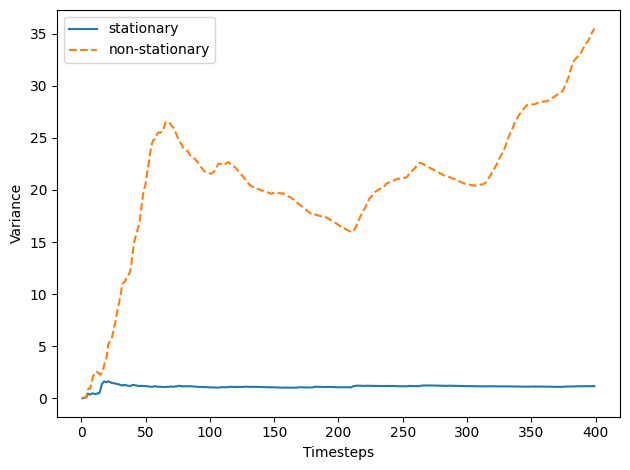

In [40]:
def var_over_time(process: np.array) -> np.array:
    var_func = []
    
    for i in range(len(process)):
        var_func.append(np.var(process[:i]))
    
    return var_func

stationary_var = var_over_time(stationary)
non_stationary_var = var_over_time(non_stationary)

fig, ax = plt.subplots()

ax.plot(stationary_var, label='stationary')
ax.plot(non_stationary_var, linestyle='--', label='non-stationary')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Variance')
ax.legend(loc=2)

plt.tight_layout()
plt.show()

### The autocorrelation function

**We know that correlation measures the extent of a linear relationship between two
variables.**

**Autocorrelation therefore measures the linear relationship between lagged
values of a time series.** Thus, the ACF reveals how the correlation between any two values
changes as the lag increases. Here, the lag is simply the number of timesteps separating
two values.

### Putting it all together

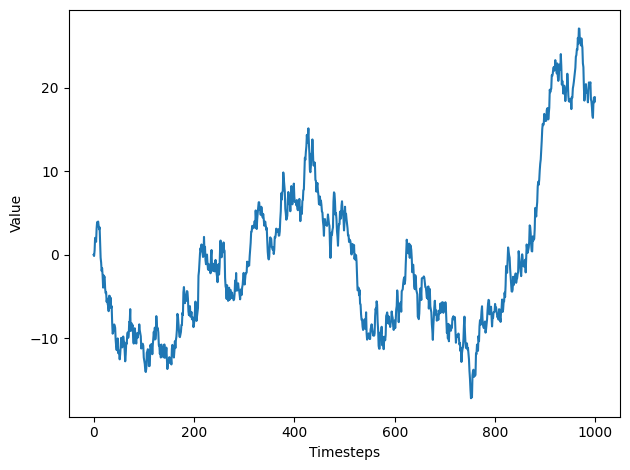

In [41]:
fig, ax = plt.subplots()

ax.plot(random_walk)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()
plt.show()

In [43]:
from statsmodels.tsa.stattools import adfuller

In [45]:
ADF_result = adfuller(random_walk)

print(f'ADF Statistic: {ADF_result[0]}')
print("Critical values:")
for key, value in ADF_result[4].items():
    print(f'   {key}: {value}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -0.9659524876918755
Critical values:
   1%: -3.4369127451400474
   5%: -2.864437475834273
   10%: -2.568312754566378
p-value: 0.7654789696692579


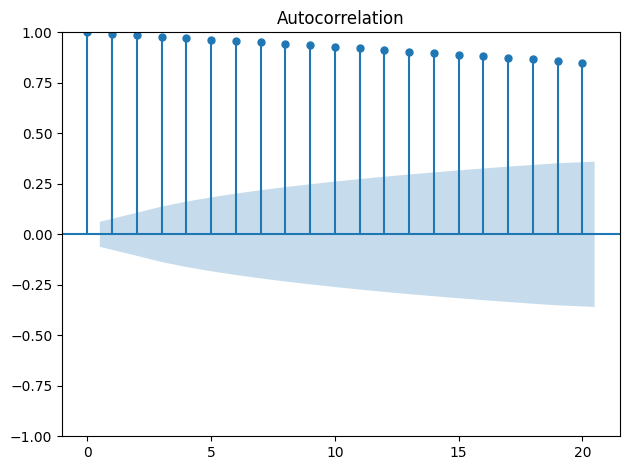

In [46]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(random_walk, lags=20);
plt.tight_layout()
plt.show()

In [47]:
diff_random_walk = np.diff(random_walk, n=1)

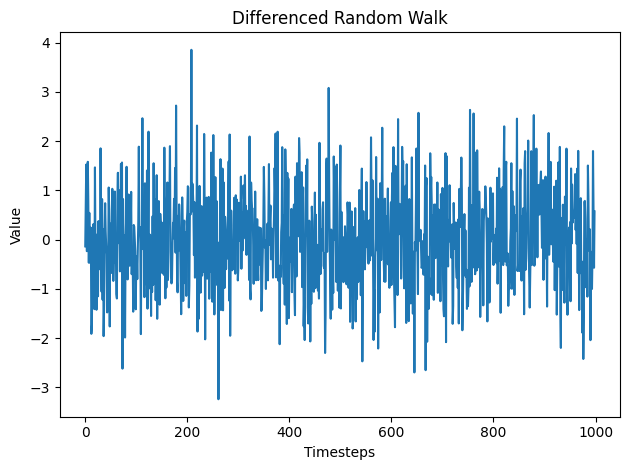

In [48]:
plt.plot(diff_random_walk)
plt.title('Differenced Random Walk')
plt.xlabel('Timesteps')
plt.ylabel('Value')
plt.tight_layout()
plt.show()

In [49]:
ADF_result = adfuller(diff_random_walk)

print(f'ADF Statistic: {ADF_result[0]}')
print("Critical values:")
for key, value in ADF_result[4].items():
    print(f'   {key}: {value}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -31.7893108575606
Critical values:
   1%: -3.4369193380671
   5%: -2.864440383452517
   10%: -2.56831430323573
p-value: 0.0


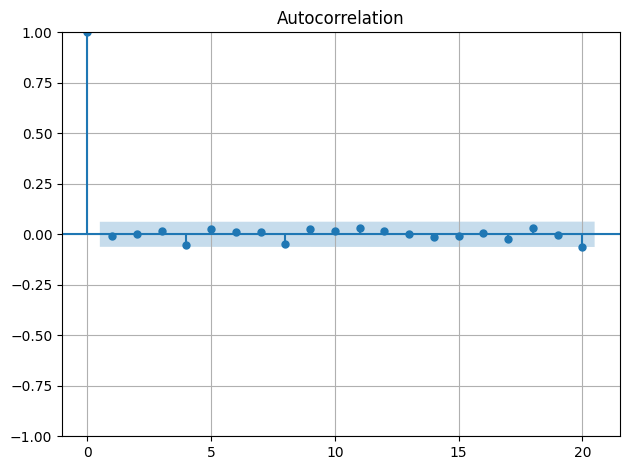

In [52]:
plot_acf(diff_random_walk, lags=20);

plt.tight_layout()
plt.grid()
plt.show()

**We have demonstrated that our simulated data is indeed a random walk: the series
is stationary and uncorrelated after a first-order differencing, which corresponds to
the definition of a random walk.**

## Is GOOGL a random walk?

In [53]:
df = pd.read_csv('data/GOOGL.csv')

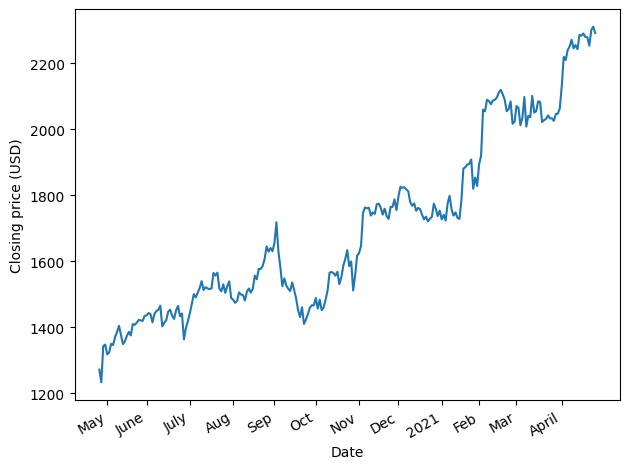

In [54]:
fig, ax = plt.subplots()
ax.plot(df['Date'], df['Close'])
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (USD)')
plt.xticks([4, 24, 46, 68, 89, 110, 132, 152, 174, 193, 212, 235],
['May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 2021, 'Feb', 'Mar', 'April'])
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [55]:
GOOGL_ADF_result = adfuller(df['Close'])

print(f'ADF Statistic: {GOOGL_ADF_result[0]}')
print("Critical values:")
for key, value in ADF_result[4].items():
    print(f'   {key}: {value}')
print(f'p-value: {GOOGL_ADF_result[1]}')

ADF Statistic: 0.16025048664771274
Critical values:
   1%: -3.4369193380671
   5%: -2.864440383452517
   10%: -2.56831430323573
p-value: 0.9699419435913057


In [56]:
diff_close = np.diff(df['Close'], n=1)

In [58]:
GOOGL_diff_ADF_result = adfuller(diff_close)

print(f'ADF Statistic: {GOOGL_diff_ADF_result[0]}')
print("Critical values:")
for key, value in ADF_result[4].items():
    print(f'   {key}: {value}')
print(f'p-value: {GOOGL_diff_ADF_result[1]}')

ADF Statistic: -5.3034397042952275
Critical values:
   1%: -3.4369193380671
   5%: -2.864440383452517
   10%: -2.56831430323573
p-value: 5.386530961454739e-06


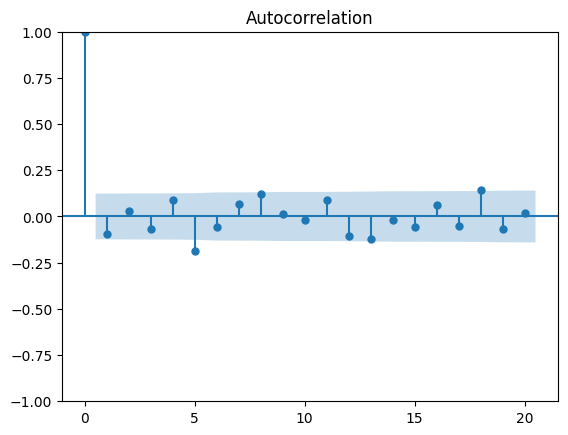

In [59]:
plot_acf(diff_close, lags=20);

## Forecasting a random walk

**Since the values change randomly, no statistical learning model can be applied.**

### Forecasting on a long horizon

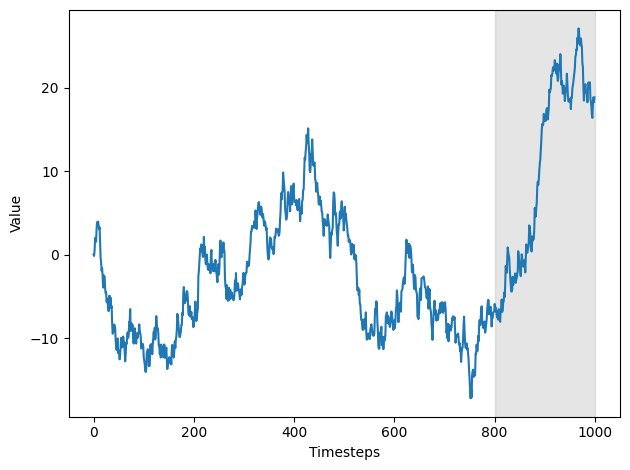

In [60]:
df = pd.DataFrame({'value': random_walk})

train = df[:800]
test = df[800:]

fig, ax = plt.subplots()

ax.plot(random_walk)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
ax.axvspan(800, 1000, color='#808080', alpha=0.2)

plt.tight_layout()

In [61]:
mean = np.mean(train.value)
test.loc[:, 'pred_mean'] = mean
test.head()

,value,pred_mean
800,-5.876664,-3.677206
801,-6.392708,-3.677206
802,-6.296588,-3.677206
803,-6.758863,-3.677206
804,-7.193359,-3.677206


In [62]:
last_value = train.iloc[-1].value
test.loc[:, 'pred_last'] = last_value
test.head()

,value,pred_mean,pred_last
800,-5.876664,-3.677206,-6.814947
801,-6.392708,-3.677206,-6.814947
802,-6.296588,-3.677206,-6.814947
803,-6.758863,-3.677206,-6.814947
804,-7.193359,-3.677206,-6.814947


In [63]:
deltaX = 800 - 1
deltaY = last_value - 0

drift = deltaY / deltaX

x_vals = np.arange(801, 1001, 1)

pred_drift = drift * x_vals

test.loc[:, 'pred_drift'] = pred_drift

test.head()

,value,pred_mean,pred_last,pred_drift
800,-5.876664,-3.677206,-6.814947,-6.832006
801,-6.392708,-3.677206,-6.814947,-6.840536
802,-6.296588,-3.677206,-6.814947,-6.849065
803,-6.758863,-3.677206,-6.814947,-6.857594
804,-7.193359,-3.677206,-6.814947,-6.866124


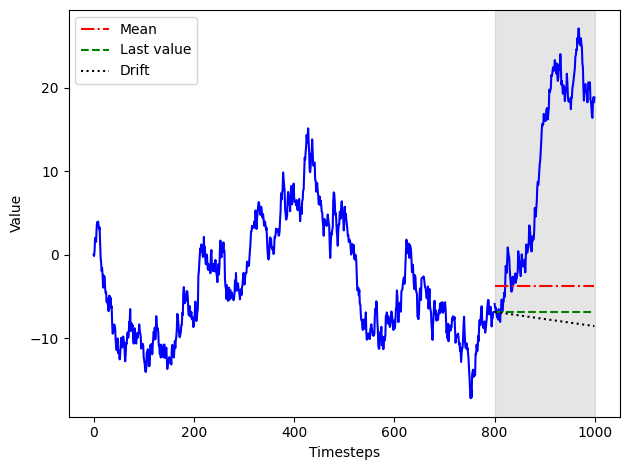

In [64]:
fig, ax = plt.subplots()

ax.plot(train.value, 'b-')
ax.plot(test['value'], 'b-')
ax.plot(test['pred_mean'], 'r-.', label='Mean')
ax.plot(test['pred_last'], 'g--', label='Last value')
ax.plot(test['pred_drift'], 'k:', label='Drift')

ax.axvspan(800, 1000, color='#808080', alpha=0.2)
ax.legend(loc=2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()

In [65]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['value'], test['pred_mean'])
mse_last = mean_squared_error(test['value'], test['pred_last'])
mse_drift = mean_squared_error(test['value'], test['pred_drift'])

print(mse_mean, mse_last, mse_drift)

326.50277395297474 425.1726033055617 466.2172769077409


### Forecasting the next timestep

In [66]:
df_shift = df.shift(periods=1)

df_shift.head()

,value
0,NaN
1,0.000000
2,-0.138264
3,0.509424
4,2.032454


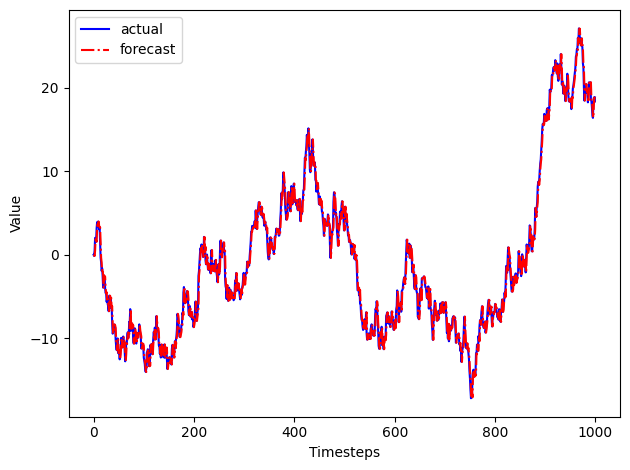

In [67]:
fig, ax = plt.subplots()

ax.plot(df, 'b-', label='actual')
ax.plot(df_shift, 'r-.', label='forecast')

ax.legend(loc=2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()

In [68]:
mse_one_step = mean_squared_error(test['value'], df_shift[800:])

mse_one_step

0.9256876651440581

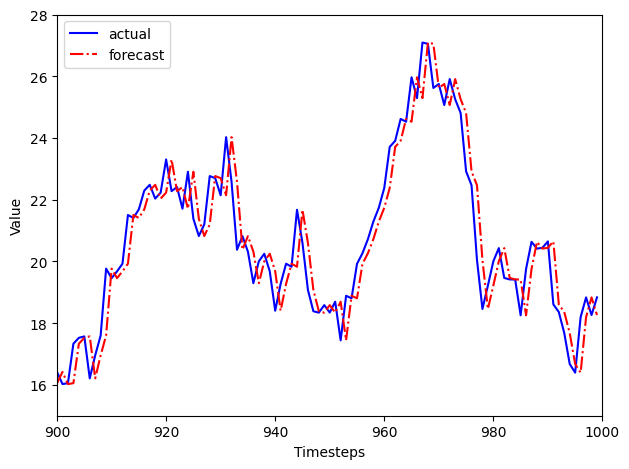

In [69]:
fig, ax = plt.subplots()

ax.plot(df, 'b-', label='actual')
ax.plot(df_shift, 'r-.', label='forecast')

ax.legend(loc=2)

ax.set_xlim(900, 1000)
ax.set_ylim(15, 28)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()

Because a **random process takes random steps into the future, we cannot use statistical
or deep learning techniques to fit such a process: there is nothing to learn from
randomness and it cannot be predicted. Instead, we must rely on naive forecasting
methods.**

> Ultimately, you cannot predict random
movements.

**We cannot use statistical or deep learning techniques on a random walk, since it
moves at random in the future. Therefore, we must use naive forecasts.**

## Forecast the daily closing price of GOOGL

In [70]:
df = pd.read_csv('data/GOOGL.csv')
df.head()

googl_train = df[['Date','Close']][:-5]
googl_test = df[['Date','Close']][-5:]

In [71]:
# Forecast the historical mean
mean = np.mean(googl_train['Close'])
googl_test.loc[:, 'pred_mean'] = mean

# Forecast using the last knwon value
last_value = googl_train['Close'].iloc[-1]
googl_test.loc[:, 'pred_last'] = last_value

# Forecast using the drift
deltaX = len(googl_train)    # The deltaX is basically the length of the training set
deltaY = last_value - googl_train['Close'].iloc[0]    # Remember to subtract the initial value of the training set

drift = deltaY / deltaX

x_vals = np.arange(248, 253, 1)

pred_drift = drift * x_vals + googl_train['Close'].iloc[0]    #A Add the initial value back in the predictions

googl_test.loc[:, 'pred_drift'] = pred_drift

googl_test

,Date,Close,pred_mean,pred_last,pred_drift
248,2021-04-21,2278.350098,1689.993184,2279.01001,2279.010010
249,2021-04-22,2252.520020,1689.993184,2279.01001,2283.075131
250,2021-04-23,2299.929932,1689.993184,2279.01001,2287.140252
251,2021-04-26,2309.929932,1689.993184,2279.01001,2291.205373
252,2021-04-27,2290.979980,1689.993184,2279.01001,2295.270494


In [72]:
googl_mse_mean = mean_squared_error(googl_test['Close'], googl_test['pred_mean'])
googl_mse_last = mean_squared_error(googl_test['Close'], googl_test['pred_last'])
googl_mse_drift = mean_squared_error(googl_test['Close'], googl_test['pred_drift'])

print(googl_mse_mean, googl_mse_last, googl_mse_drift)

356025.96701539395 447.82398976418415 293.3287644069853


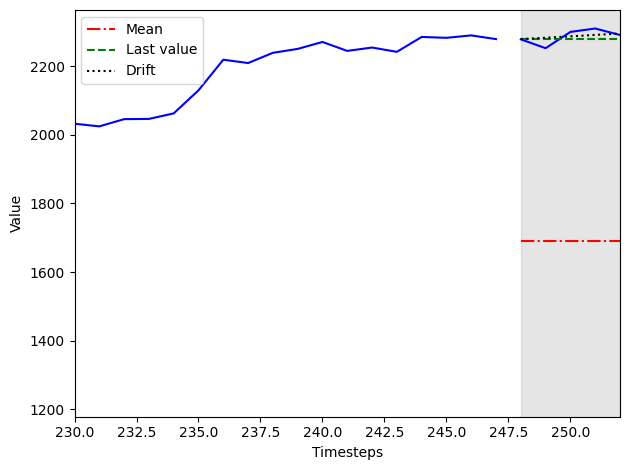

In [73]:
fig, ax = plt.subplots()

ax.plot(googl_train['Close'], 'b-')
ax.plot(googl_test['Close'], 'b-')
ax.plot(googl_test['pred_mean'], 'r-.', label='Mean')
ax.plot(googl_test['pred_last'], 'g--', label='Last value')
ax.plot(googl_test['pred_drift'], 'k:', label='Drift')

ax.axvspan(248, 252, color='#808080', alpha=0.2)
ax.legend(loc=2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.xlim(230, 252)
plt.tight_layout()

In [74]:
# Forecast the next timestep
df_shift = df.shift(periods=1)

mse_one_step = mean_squared_error(googl_test['Close'], df_shift['Close'].iloc[248:])

mse_one_step

674.8857699967758

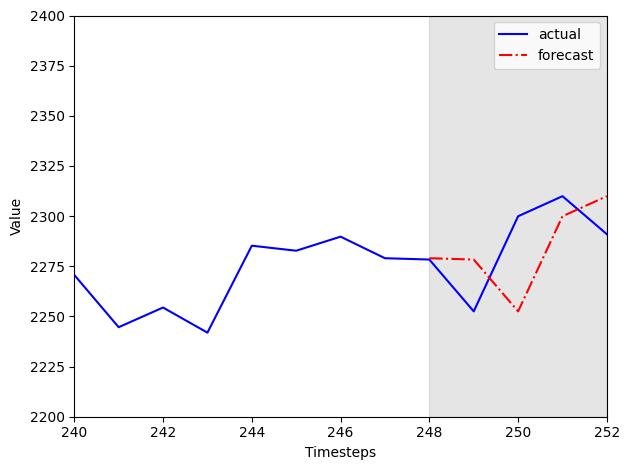

In [75]:
fig, ax = plt.subplots()

ax.plot(df['Close'], 'b-', label='actual')
ax.plot(df_shift['Close'].iloc[248:], 'r-.', label='forecast')

ax.axvspan(248, 252, color='#808080', alpha=0.2)

ax.legend(loc='best')

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.xlim(240, 252)
plt.ylim(2200, 2400)
plt.tight_layout()